<a href="https://colab.research.google.com/github/Wjh70301/AGB/blob/master/csc421_mnist_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import gzip
import sys
import struct
import urllib.request
import numpy as np

def read_image(fi):
    magic, n, rows, columns = struct.unpack(">IIII", fi.read(16))
    assert magic == 0x00000803
    assert rows == 28
    assert columns == 28
    rawbuffer = fi.read()
    assert len(rawbuffer) == n * rows * columns
    rawdata = np.frombuffer(rawbuffer, dtype='>u1', count=n*rows*columns)
    return rawdata.reshape(n, rows, columns).astype(np.float32) / 255.0

def read_label(fi):
    magic, n = struct.unpack(">II", fi.read(8))
    assert magic == 0x00000801
    rawbuffer = fi.read()
    assert len(rawbuffer) == n
    return np.frombuffer(rawbuffer, dtype='>u1', count=n)

def openurl_gzip(url):
    request = urllib.request.Request(
        url,
        headers={
            "Accept-Encoding": "gzip",
            "User-Agent": "Mozilla/5.0 (X11; U; Linux i686) Gecko/20071127 Firefox/2.0.0.11", 
        })
    response = urllib.request.urlopen(request)
    return gzip.GzipFile(fileobj=response, mode='rb')

In [0]:
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_weights(weights):
    w = weights
    w = w.reshape(w.shape[0], math.ceil(math.sqrt(w.shape[1])), 
                              math.ceil(math.sqrt(w.shape[1])))

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the fully connected layer.
    num_filters = w.shape[0]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input.
            img = w[i, :, :]

            # Plot image.
            #ax.imshow(img, vmin=w_min, vmax=w_max,
            #          interpolation='nearest', cmap='gray')
            ax.imshow(img, vmin=np.min(img), vmax=np.max(img),
                      interpolation='nearest', cmap='gray')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
def plot_single_training_example(i):
    data = np.load('mnist.npz')
    image = data['train_x'][i]
    label = data['train_y'][i]

    print(label)
    f, ax = plt.subplots(figsize=(12, 12))
    sns.heatmap(image, annot=True, fmt='.1f', square=True, cmap="YlGnBu")
    plt.show()

In [3]:
!pip install livelossplot

In [0]:
import numpy as np

np.savez_compressed(
        'mnist',
        train_x=read_image(openurl_gzip('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')),
        train_y=read_label(openurl_gzip('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')),
        test_x=read_image(openurl_gzip('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')),
        test_y=read_label(openurl_gzip('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'))
    )

In [5]:
data = np.load('mnist.npz')

print(data['train_x'].shape, data['train_x'].dtype)
print(data['train_y'].shape, data['train_y'].dtype)
print(data['test_x'].shape, data['test_x'].dtype)
print(data['test_y'].shape, data['test_y'].dtype)

(60000, 28, 28) float32
(60000,) uint8
(10000, 28, 28) float32
(10000,) uint8


3


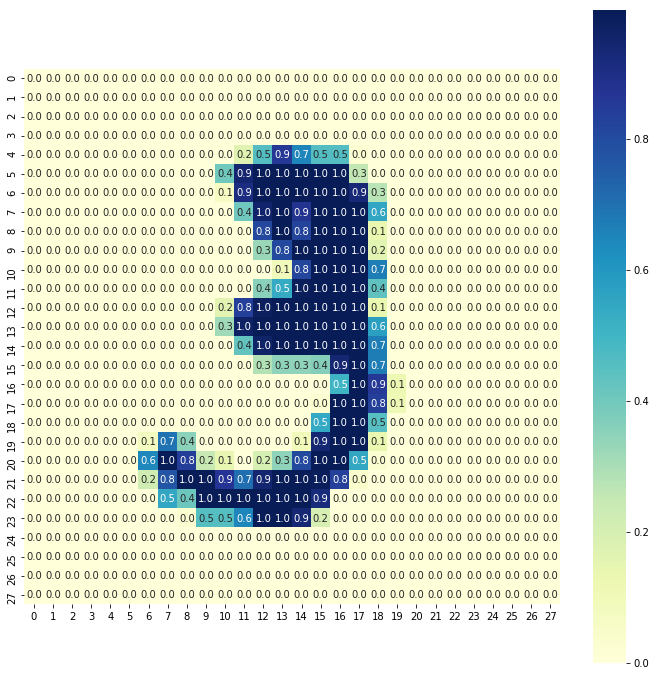

In [6]:
i = 10
plot_single_training_example(i)

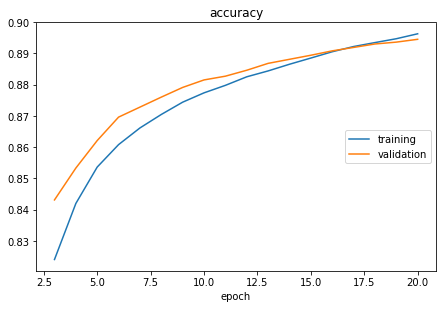

accuracy:
training   (min:    0.605, max:    0.896, cur:    0.896)
validation (min:    0.771, max:    0.894, cur:    0.894)
Accuracy: 0.8945 (test), 0.8963 (train)


In [7]:
import numpy as np
from livelossplot import PlotLosses

def softmax(x):
    # Result of softmax are invariant even if we add/subtract a constant.
    ex = np.exp(x - np.max(x))  # Subtract such that the maximum value is one.
    return ex / ex.sum(axis=0)

def image_to_vector(X):
    X = np.reshape(X, (len(X), -1))     # Flatten: (N x 28 x 28) -> (N x 784)
    return np.c_[X, np.ones(len(X))]    # Append 1: (N x 784) -> (N x 785)

def label_to_onehot(Y, K):
    return np.eye(K)[Y]              # e.g., 3 -> [0, 0, 0, 1, 0, 0, 0, 0, 0]
    
data = np.load('mnist.npz')
Xtrain = image_to_vector(data['train_x'])
Ytrain = label_to_onehot(data['train_y'], 10)
Xtest = image_to_vector(data['test_x'])
Ytest = data['test_y']

W = np.random.randn(10, 28*28+1)

eta = 0.001
liveloss = PlotLosses()
for t in range(20):
    num_correct_train = 0
    
    # Stochastic gradient descent.
    for x, y in zip(Xtrain, Ytrain):
        y_pred = softmax(np.dot(W, x))
        W += np.outer(eta * (y - y_pred), x)
        if  np.argmax(y_pred) == np.argmax(y):
            num_correct_train += 1
    
    # Evaluate and store the accuracy on the test set.
    num_correct_test = 0
    for x, y in zip(Xtest, Ytest):
        y_pred = np.argmax(np.dot(W, x))
        if y_pred == y:
            num_correct_test += 1
            
    # Visualize accuracy values on the training and test sets.
    liveloss.update({
        'accuracy': float(num_correct_train) / len(Ytrain),
        'val_accuracy': float(num_correct_test) / len(Ytest)
    })
    liveloss.draw()
    
print('Accuracy: {:.4f} (test), {:.4f} (train)'.format(
    float(num_correct_test) / len(Ytest), 
    float(num_correct_train) / len(Ytrain)
    ))

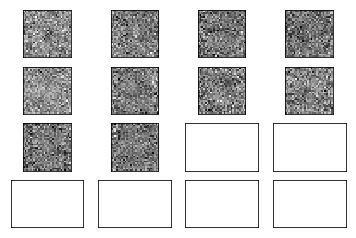

In [8]:
plot_weights(W[:,:-1])

In [9]:
!pip install torch torchvision

In [0]:
def create_dataset(x, y, flatten=False):
    if flatten:
        # Convert it into a matrix (N [samples], 28*28 [dims])
        xt = torch.from_numpy(x).view(len(x), -1)
    else:
        # Convert it into a 4D tensor (N [samples], 1 [ch], 28 [px], 28 [px])
        xt = torch.from_numpy(x).unsqueeze(1)
    yt = torch.from_numpy(y).long()
    return TensorDataset(xt, yt)

def test_model(model, loss_fn, test_loader, device):
    model.eval()

    loss = 0.
    num_correct = 0.
    for batch_idx, (x, y) in enumerate(test_loader):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss += loss_fn(y_pred, y).item()
        _, predicted = torch.max(y_pred.data, 1)
        num_correct += (predicted == y).sum().item()

    model.train()
    loss /= len(test_loader.dataset)
    num_correct /= len(test_loader.dataset)
    return loss, num_correct

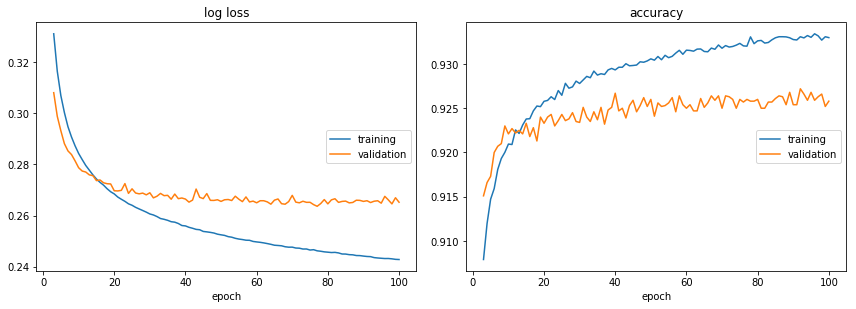

log loss:
training   (min:    0.243, max:    0.535, cur:    0.243)
validation (min:    0.264, max:    0.360, cur:    0.265)

accuracy:
training   (min:    0.866, max:    0.933, cur:    0.933)
validation (min:    0.903, max:    0.927, cur:    0.926)
Accuracy: 0.9258 (test), 0.9330 (train)


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from livelossplot import PlotLosses

#device = torch.device("cpu") # Uncomment this to run on CPU
device = torch.device("cuda:0") # Uncomment this to run on GPU

model = nn.Sequential()
model.add_module('fc1', nn.Linear(784, 10, bias=True))
print(model)
model.to(device)

data = np.load('mnist.npz')
train_set = create_dataset(data['train_x'], data['train_y'], flatten=True)
test_set = create_dataset(data['test_x'], data['test_y'], flatten=True)
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128)

loss_fn = nn.CrossEntropyLoss(size_average=False)
optimizer = optim.SGD(model.parameters(), lr=0.001)

liveloss = PlotLosses()
for t in range(100):
    train_loss = 0.
    train_correct = 0
    
    # Training loop for mini-batches
    for batch_idx, (x, y) in enumerate(train_loader):
        # Make predictions with the current parameters.
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        _, predicted = torch.max(y_pred.data, 1)
        train_correct += (predicted == y).sum().item()
        
        # Compute the loss value.
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Update the parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Compute the average loss and accuracy.
    train_loss /= len(train_loader.dataset)
    train_correct /= float(len(train_loader.dataset))
    
    # Evaluate the model on the test set.
    test_loss, test_correct = test_model(model, loss_fn, test_loader, device)

    # Visualize the loss and accuracy values.
    liveloss.update({
        'log loss': train_loss,
        'val_log loss': test_loss,
        'accuracy': train_correct,
        'val_accuracy': test_correct,
    })
    liveloss.draw()

print('Accuracy: {:.4f} (test), {:.4f} (train)'.format(test_correct, train_correct))

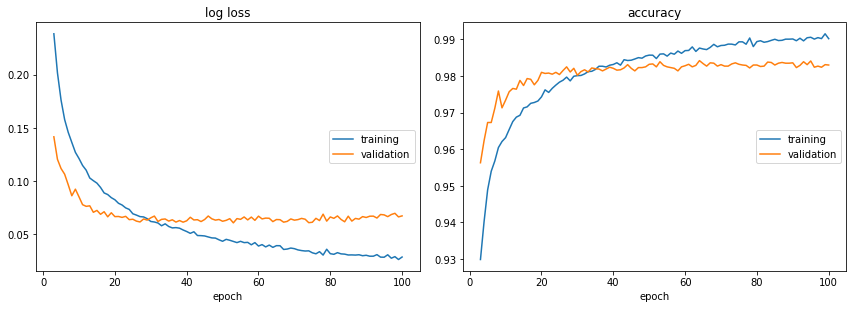

log loss:
training   (min:    0.026, max:    0.776, cur:    0.028)
validation (min:    0.061, max:    0.268, cur:    0.067)

accuracy:
training   (min:    0.758, max:    0.992, cur:    0.990)
validation (min:    0.922, max:    0.984, cur:    0.983)
Accuracy: 0.9830 (test), 0.9902 (train)


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from livelossplot import PlotLosses


#device = torch.device("cpu") # Uncomment this to run on CPU
device = torch.device("cuda:0") # Uncomment this to run on GPU

model = nn.Sequential()
model.add_module('fc1',      nn.Linear(784, 256))
model.add_module('relu1',    nn.ReLU())
model.add_module('dropout1', nn.Dropout())
model.add_module('fc2',      nn.Linear(256, 256))
model.add_module('relu2',    nn.ReLU())
model.add_module('dropout2', nn.Dropout())
model.add_module('fc3',      nn.Linear(256, 10))
print(model)
model.to(device)

data = np.load('mnist.npz')
train_set = create_dataset(data['train_x'], data['train_y'], flatten=True)
test_set = create_dataset(data['test_x'], data['test_y'], flatten=True)
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128)

loss_fn = nn.CrossEntropyLoss(size_average=False)
optimizer = optim.SGD(model.parameters(), lr=0.001)

liveloss = PlotLosses()
for t in range(100):
    train_loss = 0.
    train_correct = 0
    
    # Training loop for mini-batches
    for batch_idx, (x, y) in enumerate(train_loader):
        # Make predictions with the current parameters.
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        _, predicted = torch.max(y_pred.data, 1)
        train_correct += (predicted == y).sum().item()
        
        # Compute the loss value.
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Update the parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Compute the average loss and accuracy.
    train_loss /= len(train_loader.dataset)
    train_correct /= float(len(train_loader.dataset))
    
    # Evaluate the model on the test set.
    test_loss, test_correct = test_model(model, loss_fn, test_loader, device)

    # Visualize the loss and accuracy values.
    liveloss.update({
        'log loss': train_loss,
        'val_log loss': test_loss,
        'accuracy': train_correct,
        'val_accuracy': test_correct,
    })
    liveloss.draw()

print('Accuracy: {:.4f} (test), {:.4f} (train)'.format(test_correct, train_correct))